In [6]:
import pandas as pd
import numpy as np
import re
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout, Embedding
from keras import optimizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [7]:
# 1. Chargement des données
train_data = pd.read_csv('SQLIV3_cleaned2.csv')
test_data = pd.read_csv('sqliv2_utf8.csv')

In [8]:
# 2. Suppression des doublons (en gardant la première occurrence)
train_data.drop_duplicates(subset='Sentence', keep='first', inplace=True)
test_data.drop_duplicates(subset='Sentence', keep='first', inplace=True)


In [9]:
# 3. Nettoyage MINIMAL (on conserve les caractères spéciaux !)
def clean_text(text):
    text = str(text).strip()  # Conversion en string + suppression espaces inutiles
    return text

In [10]:
train_data['Sentence'] = train_data['Sentence'].apply(clean_text)
test_data['Sentence'] = test_data['Sentence'].apply(clean_text)

In [11]:
# 4. Tokenisation (on garde tous les caractères)
vocab_size = 15000  # Vocabulaire large pour les motifs SQL
tokenizer = Tokenizer(
    num_words=vocab_size,
    oov_token="<OOV>",
    filters='',       # ← AUCUN filtre (conserve ', ", ;, -- etc.)
    lower=False       # ← Conserve la casse (important pour SQL)
)
tokenizer.fit_on_texts(train_data['Sentence'])

In [12]:
# 5. Padding adaptatif
max_len = int(np.percentile([len(x.split()) for x in train_data['Sentence']], 95))
X = tokenizer.texts_to_sequences(train_data['Sentence'])
X = pad_sequences(X, padding='post', maxlen=max_len)
y = train_data['Label'].astype('int')


In [13]:
# 6. Split train/validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# 7. Architecture du modèle
embedding_dim = 256  # Grande dimension pour les caractères spéciaux
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    SimpleRNN(256, return_sequences=True),  # Couche 1: capture les motifs locaux
    Dropout(0.3),
    SimpleRNN(128),                         # Couche 2: agrège les motifs
    Dense(64, activation='relu'),           # Couche dense intermédiaire
    Dense(1, activation='sigmoid')          # Sortie binaire
])

In [15]:
# 8. Optimisation
optimizer = optimizers.Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [16]:
# 9. Entraînement
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_val, y_val),
)

Epoch 1/20
383/383 [==============================] - 39s 94ms/step - loss: 0.0603 - accuracy: 0.9824 - val_loss: 0.0257 - val_accuracy: 0.9956
Epoch 2/20
383/383 [==============================] - 35s 91ms/step - loss: 0.0201 - accuracy: 0.9953 - val_loss: 0.0144 - val_accuracy: 0.9969
Epoch 3/20
383/383 [==============================] - 35s 93ms/step - loss: 0.0128 - accuracy: 0.9969 - val_loss: 0.0341 - val_accuracy: 0.9933
Epoch 4/20
383/383 [==============================] - 36s 94ms/step - loss: 0.0127 - accuracy: 0.9973 - val_loss: 0.0261 - val_accuracy: 0.9958
Epoch 5/20
383/383 [==============================] - 36s 93ms/step - loss: 0.0114 - accuracy: 0.9979 - val_loss: 0.0848 - val_accuracy: 0.9910
Epoch 6/20
383/383 [==============================] - 36s 93ms/step - loss: 0.0265 - accuracy: 0.9958 - val_loss: 0.0354 - val_accuracy: 0.9941
Epoch 7/20
383/383 [==============================] - 35s 93ms/step - loss: 0.0276 - accuracy: 0.9955 - val_loss: 0.0265 - val_accuracy:

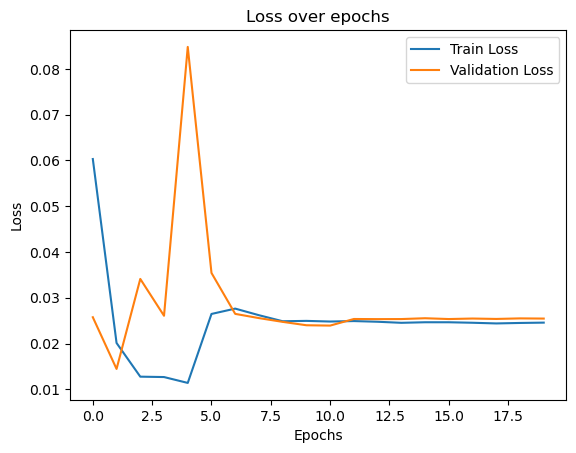

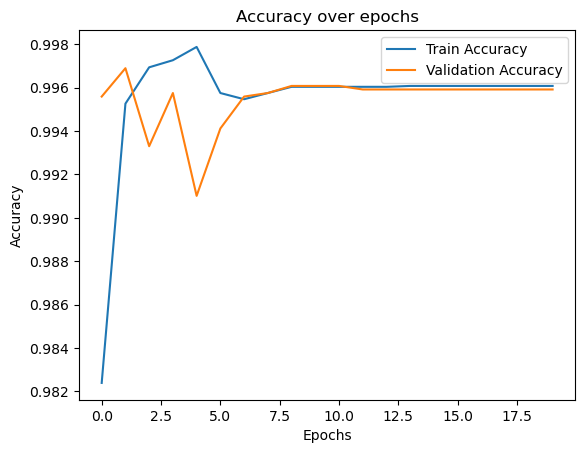

In [19]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [17]:
# 10. Évaluation
X_test = tokenizer.texts_to_sequences(test_data['Sentence'])
X_test = pad_sequences(X_test, padding='post', maxlen=max_len)
test_loss, test_accuracy = model.evaluate(X_test, test_data['Label'].astype('int'))
print(f'\nTest Accuracy: {test_accuracy:.4f}')

1054/1054 [==============================] - 18s 17ms/step - loss: 0.0666 - accuracy: 0.9908

Test Accuracy: 0.9908


In [27]:
from sklearn.metrics import classification_report

# 1. Récupérer uniquement les lignes spam (Label = 1)
sqli_only = test_data[test_data['Label'] == 1].copy()
print(f"\n📌 Nombre total des injection sql dans test_data : {len(sqli_only)}")


📌 Nombre total des injection sql dans test_data : 11424


In [28]:
# 2. Nettoyage si besoin
sqli_only['Sentence'] = sqli_only['Sentence'].apply(clean_text)

In [29]:
# 3. Tokenisation + Padding
X_sqli = tokenizer.texts_to_sequences(sqli_only['Sentence'])
X_sqli = pad_sequences(X_sqli, padding='post', maxlen=max_len)

In [32]:
# 4. Prédiction
sqli_preds = model.predict(X_sqli)
sqli_preds_labels = (sqli_preds > 0.5).astype(int)

357/357 [==============================] - 6s 16ms/step


In [33]:
# 5. Calcul du nombre de spams correctement détectés
true_positives = np.sum(sqli_preds_labels == 1)
total_sqli = len(sqli_only)
detection_rate = (true_positives / total_sqli) * 100

In [34]:
# 6. Affichage
print(f"✅ Spams correctement détectés : {true_positives}")
print(f"📊 Taux de détection : {detection_rate:.2f}%")


✅ Spams correctement détectés : 11274
📊 Taux de détection : 98.69%
